In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch.nn as nn
from DNN import DeepNet
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device) # default tensor device
print("I'm using: ", device)

I'm using:  cpu
I'm using:  cpu


## A non-linear boundary value problem
We consider the problem
$$
\begin{cases}
    \displaystyle -\frac{d}{dx}\Big[(1+u(x)^2)\frac{d}{dx}u\Big] = -2\pi^2\cos(\pi x)^2\sin(\pi x) +  \pi^2 \sin(\pi x)\big(\sin(\pi x)^2 +1\big) =: f(x), \quad x \in (0,2) \\[15pt] 
    u(0) = u(2) = 0
\end{cases}
$$
Which is solved by $u(x) = \sin(\pi x)$.

We start by introducing some helper functions.

In [2]:
def convert(x):
  return x.cpu().detach().numpy()

def L2_diff(y, y_pred):
  return np.linalg.norm(y-y_pred,2)

Define a network `FNN`  with 5 layers, 20 neurons and tanh (https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#tanh) as the activation function

In [3]:
input = 1
output = 1
hidden_layer = 5*[20]
activation_function = nn.Tanh()

FNN = DeepNet(activation_function,input,hidden_layer,output)
FNN

DeepNet(
  (activation): Tanh()
  (hidden): ModuleList(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1-4): 4 x Linear(in_features=20, out_features=20, bias=True)
  )
  (output): Linear(in_features=20, out_features=1, bias=False)
)

Using `torch.rand`, define the points that will be used for training. For the test points, we use equispaced points that can be defined with `torch.linspace`

In [4]:
x0 = torch.Tensor([0]).to(device)
x1 = torch.Tensor([2]).to(device)
u_b0 = torch.Tensor([0]).to(device)
u_b1 = torch.Tensor([0]).to(device)

n_train_points = 200 
n_test_points  = 500

x_train = 2*torch.rand([n_train_points, 1])
x_sort_train,_ = torch.sort(x_train,0)
x_test  = torch.linspace(0,2,n_test_points).unsqueeze(1)

Visualize the points

Text(0.5, 1.0, 'Collocation Points')

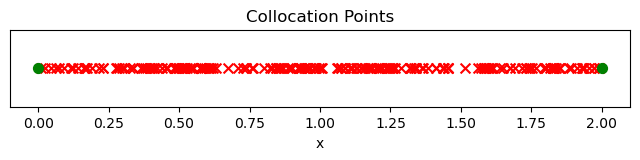

In [5]:
%matplotlib inline
plt.figure(figsize=(8, 1))  
plt.scatter(convert(x_train), np.zeros_like(convert(x_train)), color='red', s=50, marker='x', label='Collocation Points')
plt.scatter(convert(x0), np.zeros_like(convert(x0)), color='green', s=50, label='Collocation Points')
plt.scatter(convert(x1), np.zeros_like(convert(x1)), color='green', s=50, label='Collocation Points')
plt.xlabel('x')
plt.yticks([])  
plt.title('Collocation Points')

Define the exact solution and right hand side

In [6]:
def rhs(x):
    # input a torch tensor, output a torch tensor
    return  - 2*torch.pi**2*torch.cos(torch.pi*x)**2*torch.sin(torch.pi*x) + torch.pi**2*torch.sin(torch.pi*x)*(torch.sin(torch.pi*x)**2 + 1)
def exact_sol(x):
    # input a torch tensor, output a numpy one, using the function convert
    return np.sin(np.pi*convert(x)) 

In this case, we define a function that computes the loss from 
- the NN $\Phi$ approximating the solution
- a vector of points $(x_i)_i$
- the right hand side function $f$
- a metric computing the distance between the lhs and the rhs
The function has to compute the term
$$
-\frac{d}{dx}\left((1+\Phi^2)\frac{d}{dx}\Phi\right)
$$
on the vector of points $(x_i)_i$.  To compute first and second derivatives use `torch.autograd.grad`. You will have to `create_graph=True` and `retain_graph=True`.

In [7]:
def eval_loss_ode(Phi, x, rhs, metric):
    x.requires_grad_(True) 
    u_NN = Phi(x_train)
    u_NN_x = torch.autograd.grad(u_NN.sum(), x, create_graph=True, retain_graph=True)[0]
    u_NN_x = (1+u_NN*u_NN) * u_NN_x
    u_NN_xx = torch.autograd.grad(u_NN_x.sum(), x, create_graph=True)[0]
    return metric(-u_NN_xx, rhs(x))

def eval_loss_pt(Phi, x, y):
    return (Phi(x) - y).pow(2).squeeze()

We train the network, as in the previous case.

In [8]:
n_epochs = 5000
learining_rate = 1e-3
optimizer = torch.optim.Adam(FNN.parameters(),learining_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,50,0.96)

loss_values = np.empty([n_epochs+1,4]); #total,ode, b0,b1
MSE =  torch.nn.MSELoss()
STEP = 100 #save every 100 epochs

assert n_epochs%STEP == 0

err = np.empty([int(n_epochs/STEP)+1,2])
u_animate =  np.empty([int(n_epochs/STEP)+1,n_train_points])
err_animate = np.empty([int(n_epochs/STEP)+1,n_train_points])
k = 0 

rhs_train = rhs(x_train)
u_exact_train = exact_sol(x_train)
rhs_train_sort = rhs(x_sort_train)
u_exact_train_sort = exact_sol(x_sort_train)

rhs_test = rhs(x_test)
u_exact_test = exact_sol(x_test)

for epoch in range(n_epochs+1):
    loss_ode = eval_loss_ode(FNN, x_train, rhs, MSE)

    loss_b0 = eval_loss_pt(FNN, x0, u_b0)
    loss_b1 = eval_loss_pt(FNN, x1, u_b1)

    loss = loss_ode + loss_b0 + loss_b1

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_values[epoch,:] = np.stack([convert(loss),convert(loss_ode),convert(loss_b0),convert(loss_b1)])

    if epoch%STEP == 0:
      lr = np.array(scheduler.get_last_lr())
      u_NN_test =  FNN(x_test)
      err[k,:] = [L2_diff(convert(FNN(x_train)),u_exact_train), L2_diff(convert(u_NN_test),u_exact_test)]
      u_animate[k,:]  = convert(FNN(x_sort_train).squeeze())
      err_animate[k,:]= (np.abs(u_animate[k,:] - u_exact_train_sort.squeeze()))
      print(f'Epoch {epoch} || learning rate {lr.squeeze():.2e}  || Error  Train {err[k,0]:.2e} || Error Test  {err[k,1]:.2e}''\n'
            f'Global loss {loss_values[epoch,0]:.2e} || loss ode {loss_values[epoch,1]:.2e} || loss b0 {loss_values[epoch,2]:.2e} || loss b1 {loss_values[epoch,3]:.2e}','\n')
      k+=1

Epoch 0 || learning rate 1.00e-03  || Error  Train 1.05e+01 || Error Test  1.65e+01
Global loss 1.12e+02 || loss ode 1.12e+02 || loss b0 6.45e-02 || loss b1 4.83e-02 

Epoch 100 || learning rate 9.22e-04  || Error  Train 2.14e+01 || Error Test  3.48e+01
Global loss 5.83e+01 || loss ode 5.30e+01 || loss b0 4.40e+00 || loss b1 8.22e-01 

Epoch 200 || learning rate 8.49e-04  || Error  Train 2.35e+01 || Error Test  3.80e+01
Global loss 1.32e+01 || loss ode 5.13e+00 || loss b0 4.10e+00 || loss b1 3.98e+00 

Epoch 300 || learning rate 7.83e-04  || Error  Train 2.09e+01 || Error Test  3.39e+01
Global loss 1.06e+01 || loss ode 3.84e+00 || loss b0 3.40e+00 || loss b1 3.35e+00 

Epoch 400 || learning rate 7.21e-04  || Error  Train 1.33e+01 || Error Test  2.18e+01
Global loss 4.05e+00 || loss ode 4.03e-01 || loss b0 1.75e+00 || loss b1 1.90e+00 

Epoch 500 || learning rate 6.65e-04  || Error  Train 3.97e+00 || Error Test  6.12e+00
Global loss 4.20e-01 || loss ode 2.50e-01 || loss b0 2.30e-02 || l

# Visualization of the results
Value of the loss function at the vary of the epochs

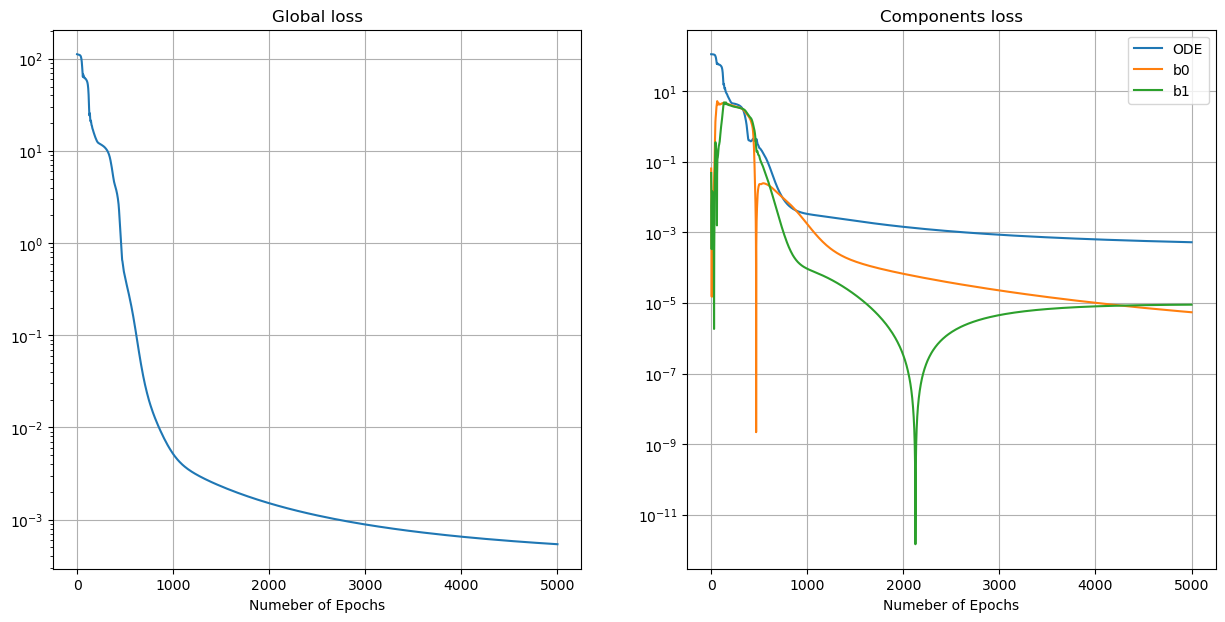

In [9]:
epochs = range(n_epochs+1)
#y_lims = [np.min(loss_values)*0.8,np.max(loss_values)*1.2]

fig, axs = plt.subplots(1,2,figsize = (15,7), num =4)
axs[0].semilogy(epochs,loss_values[:,0])
axs[0].set_xlabel('Numeber of Epochs')
#axs[0].set_ylim(y_lims)
axs[0].grid('on')
axs[0].set_title('Global loss')

axs[1].semilogy(epochs,loss_values[:,1],label = 'ODE')
axs[1].semilogy(epochs,loss_values[:,2],label = 'b0' )
axs[1].semilogy(epochs,loss_values[:,3],label = 'b1' )
axs[1].set_xlabel('Numeber of Epochs')
#axs[1].set_ylim(y_lims)
axs[1].legend()
axs[1].grid('on')
axs[1].set_title('Components loss')

plt.show()

Compare the exact solution with the PINN prediction and evaluate the point-wise error

In [10]:
x_test = convert(x_test)
u_NN_test = convert(u_NN_test)
x_sort_train = convert(x_sort_train)

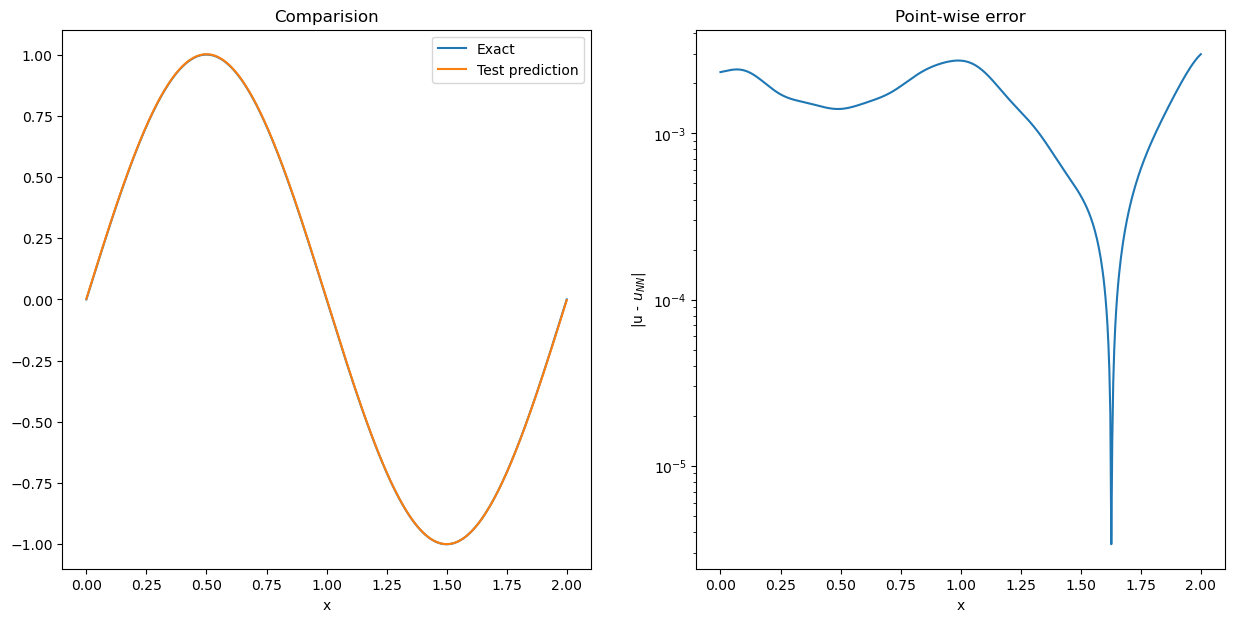

In [11]:
fig, axs = plt.subplots(1,2,figsize = (15,7))
axs[0].plot(x_test,u_exact_test,label = 'Exact')
axs[0].plot(x_test,u_NN_test, label = 'Test prediction')
axs[0].set_xlabel('x')
axs[0].legend()
axs[0].set_title('Comparision')

axs[1].semilogy(x_test,np.abs(u_exact_test-u_NN_test))
axs[1].set_title('Point-wise error')
axs[1].set_xlabel('x')
axs[1].set_ylabel('|u - $u_{NN}$|')
plt.show()

$L^2$ Errors

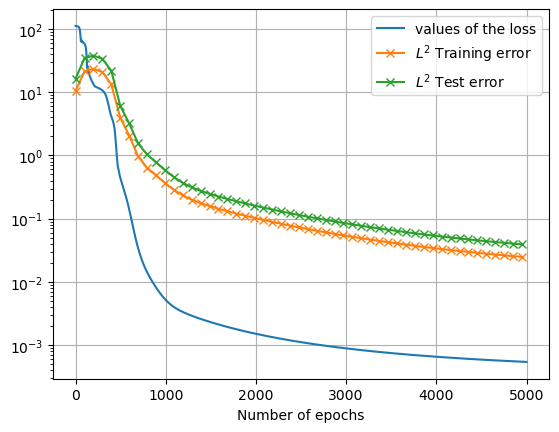

In [12]:
epochs = range(n_epochs+1)
y_lims = [np.min(loss_values)*0.8,np.max(loss_values)*1.2]

plt.semilogy(epochs,loss_values[:,0],label = 'values of the loss')
plt.semilogy(epochs[0:-1:STEP-1],err[:,0],'-x', label = '$L^2$ Training error')
plt.semilogy(epochs[0:-1:STEP-1],err[:,1],'-x', label = '$L^2$ Test error')

plt.xlabel('Number of epochs')
plt.grid('on')
plt.legend()
plt.show()

Animation of the solution and of the point wise error during training

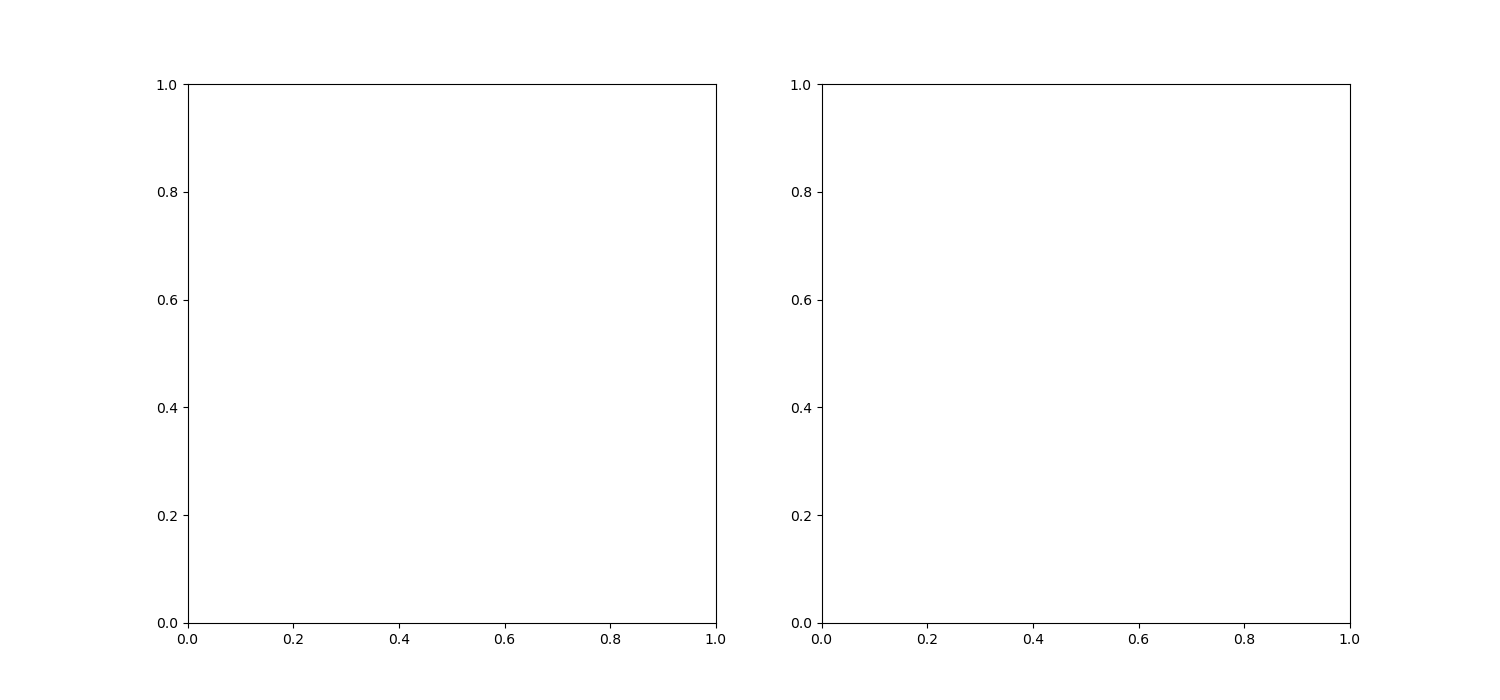

In [13]:
%matplotlib widget
fig, axs = plt.subplots(1,2, figsize = (15,7),num = 3)

def updata_data(frame):
    axs[0].clear()
    axs[0].plot(x_sort_train,u_animate[frame,:],'b--',label = r'$y_{\Theta}$')
    axs[0].plot(x_sort_train,u_exact_train_sort,'r', label = 'Exact')
    axs[0].set_ylim([-np.max(u_animate),np.max(u_animate)])
    axs[0].set_xlim([0,2])
    axs[0].set_xlabel('t')

    axs[0].grid('on')
    axs[0].legend()

    axs[1].clear()
    axs[1].semilogy(x_sort_train,err_animate[frame,:])
    axs[1].grid('on')
    axs[1].set_ylim([np.min(err_animate)*0.9,np.max(err_animate)*1.1])
    axs[1].set_xlabel('t')
    axs[1].set_title(r'$|y - y_{\Theta}|$')
    plt.suptitle(f'Epoch {frame*STEP} || error {err[frame,0]:.2e}')
    return axs[0]

animation = FuncAnimation(fig,func = updata_data,frames=len(u_animate),interval = 500,)
plt.show()
# for google colab
# from IPython.display import HTML
# video = HTML(animation.to_html5_video())
# display(video)
# plt.close()
